In [2]:
#!usr/bin/python

""" Derives a trend for temperature range w.r.t. absolute latitude
    using the FLUXNET nighttime-only, cleaned dataset."""

__author__ = 'Katie Hindson (kah15@ic.ac.uk)'
__version__ = '0.0.1'
		
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.patches as mpatches
import random
%matplotlib inline

## This is using the data's ranges split by 10 degrees bands

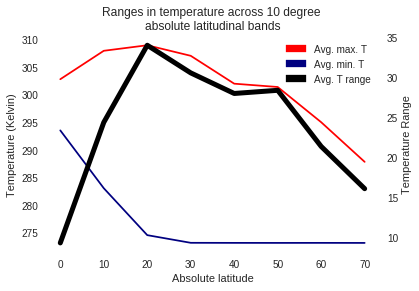

In [3]:
temp_range_all = pd.read_csv("../Data/median_temps/lognormal_dist/temp_wrt_lat/temp_ranges_sites.csv")
                          
# making a plot of the latitude vs. temperature range (All lats)

fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.plot(temp_range_all.lats_num, temp_range_all.min_temps, color = 'navy', label = 'Avg. min. T')
ax1.set(xlabel='Absolute latitude', ylabel='Temperature (Kelvin)', 
        title = 'Ranges in temperature across 10 degree \nabsolute latitudinal bands')
plt.plot(temp_range_all.lats_num, temp_range_all.max_temps, color = 'red', label = 'Avg. max. T')
ax1.set_facecolor('white')
ax1.grid(False)
ax2 = ax1.twinx()
plt.plot(temp_range_all.lats_num, temp_range_all.T_range, color = 'black', label = 'Avg. T range', linewidth = 5)
ax2.set(ylabel='Temperature Range')
ax2.set_facecolor('white')
ax2.grid(False)

red_patch = mpatches.Patch(color = 'red', label = 'Avg. max. T')
blue_patch = mpatches.Patch(color='navy',  label = 'Avg. min. T')
black_patch = mpatches.Patch(color = 'black', label = 'Avg. T range')
plt.legend(handles=[red_patch, blue_patch, black_patch])

## Building a data frame with simulation having temp range w.r.t. abs. lat. and the actual fluxnet fit results 

In [4]:
sim_df = pd.read_csv('../Results/median_temps/lognormal_dist/temp_wrt_lat/med_temps_NOT_CONVERTED_constant_species_15_simulated_E_B0.csv')
actual_df = pd.read_csv("../Results/median_temps/sites_boltz_fit_median_temps_only_results.csv")
fluxnet_df = pd.read_pickle("../Data/median_temps/fluxnet_median_temps_only.pkl")

# sorting into ascending order of siteID values since this way the indexing of the 
# two data frames will be the same.

actual_df = actual_df.sort_values(by = 'site_ID', ascending = True)
sim_df = sim_df.sort_values(by = 'siteID', ascending = True)

# getting the simulated E and lnB0 values as the means of the 150 iterations
E_sim_mean = sim_df.groupby('siteID')['E'].mean().tolist()
E_sim_median = sim_df.groupby('siteID')['E'].median().tolist()
E_actual_temp_range = np.array(fluxnet_df.groupby('siteID')['TA_F_inKelvin'].max()) - np.array(fluxnet_df.groupby('siteID')['TA_F_inKelvin'].min())

# Making a data frame of the site IDs and their corresponding E simulated and E actual.

E_vals = pd.DataFrame({'siteID' : actual_df.site_ID, 'E_sim_mean' : E_sim_mean,
                       'E_sim_median' : E_sim_median, 'E_actual' : actual_df.E, 
                       'lat': actual_df.lat, 'actual_temp_range' : E_actual_temp_range})

# removing any values that are Nan
E_vals = E_vals[E_vals.siteID.notnull()]
E_vals = E_vals[E_vals.E_sim_mean.notnull()]
E_vals = E_vals[E_vals.E_sim_median.notnull()]
E_vals = E_vals[E_vals.E_actual.notnull()]
E_vals = E_vals[E_vals.E_sim_mean != -np.inf]
E_vals = E_vals[E_vals.E_actual > 0]
E_vals = E_vals[E_vals.E_actual < 2]

## Plotting the function that temperature range is following w.r.t. lat (that is implemented in the simulation)

Polynomial fitted: -0.01x^2 + 0.66x + 13.98
R-squared value fo the fit: 0.153399152076


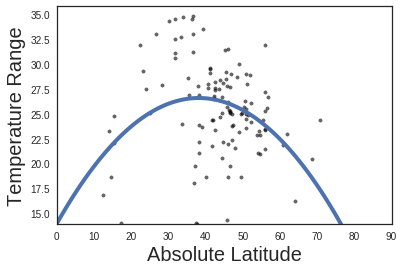

In [5]:
coeffs = np.polyfit(np.abs(E_vals.lat), E_vals.actual_temp_range, 2)
p = np.poly1d(coeffs)
xp = np.linspace(0, 80, 100)
min_val = min(E_vals.actual_temp_range) + 1
max_val = max(E_vals.actual_temp_range) + 1

boundaries = [0, 36.0, 41.0, 46.0, 50.0, 90]


with plt.style.context("seaborn-white"):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    plt.scatter(np.abs(E_vals.lat), E_vals.actual_temp_range, color = 'black', alpha = 0.6, s = 12)
    plt.plot(xp, p(xp), '-', linewidth = 4)
    plt.xlabel('Absolute Latitude', fontsize = 20)
    plt.ylabel('Temperature Range', fontsize = 20)
    #plt.title('Absolute latitude vs. temperature \nranges for sites in Fluxnet', fontsize = 16)
    plt.xlim([0, 90])
    plt.ylim([min_val, max_val])
    
    #plt.fill([boundaries[0], boundaries[1], boundaries[1], boundaries[0]], [min_val, min_val, max_val, max_val], 
    #         'gainsboro', alpha = 0.1)
    #plt.fill([boundaries[1], boundaries[2], boundaries[2], boundaries[1]], 
    #         [min_val, min_val, max_val, max_val], 'darkgray', alpha = 0.2)
    #plt.fill([boundaries[2], boundaries[3], boundaries[3], boundaries[2]], 
    #         [min_val, min_val, max_val, max_val], 'dimgray', alpha = 0.2)
    #plt.fill([boundaries[3], boundaries[4], boundaries[4], boundaries[3]], 
    ##         [min_val, min_val, max_val, max_val], 'black', alpha = 0.2)
    #plt.fill([boundaries[4], boundaries[5], boundaries[5], boundaries[4]], [min_val, min_val, max_val, max_val], 
    #         'black', alpha = 0.3)
    
    results = {}
    # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()


    # fit values, and mean
    yhat = p(np.abs(E_vals.lat))                       # or [p(z) for z in x]
    ybar = np.sum(E_vals.actual_temp_range)/len(E_vals.actual_temp_range)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((E_vals.actual_temp_range - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot
    
print('Polynomial fitted: ' + str(round(results['polynomial'][0], 2)) + 'x^2 + ' + str(round(results['polynomial'][1], 2)) + 'x + ' + str(round(results['polynomial'][2], 2)))
print('R-squared value fo the fit: ' + str(results['determination']))